In [ ]:
# Helper function to check if the code is running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Usage
if is_colab():
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools


In [3]:
if (len(tf.config.list_physical_devices('GPU')) > 0):
    len(tf.config.list_physical_devices('GPU'))
    print("Running on GPU")
else:
    tf.config.set_visible_devices([], 'GPU')
    print("Running on CPU")

NameError: name 'tf' is not defined

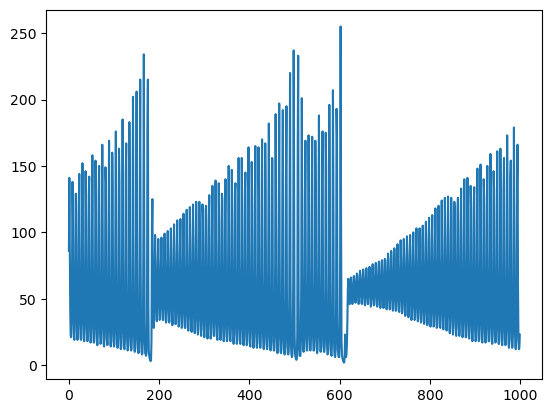

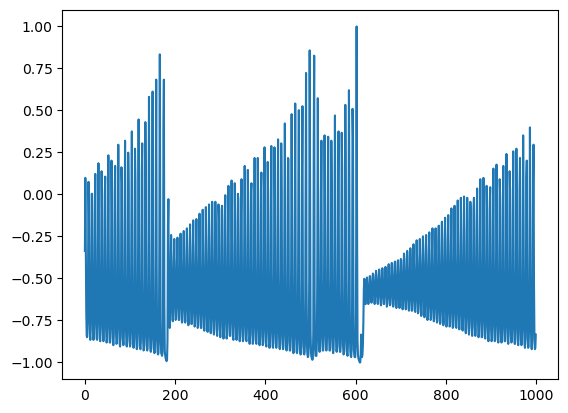

In [6]:
data = scipy.io.loadmat("./Data/Xtrain.mat")
df = pd.DataFrame(data['Xtrain'])

plt.plot(df)
plt.show()
dataset = df.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
plt.plot(dataset)

In [8]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def recursive_forecast(model, last_values, steps, lookback, device):
    model.eval()
    input_seq = torch.tensor(last_values[-lookback:], dtype=torch.float32).view(1, lookback, 1).to(device)
    preds = []

    for _ in range(steps):
        with torch.no_grad():
            pred = model(input_seq)
        preds.append(pred.item())
        next_input = torch.tensor([[pred.item()]], dtype=torch.float32).view(1, 1, 1).to(device)
        input_seq = torch.cat((input_seq[:, 1:, :], next_input), dim=1)

    return np.array(preds).reshape(-1, 1)


In [31]:
class RNNModel(nn.Module):
    def __init__(self, cell_type='RNN', input_size=1, hidden_size=64):
        super().__init__()
        if cell_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=2, nonlinearity='relu')
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=2)
        else:
            raise ValueError("Unsupported RNN type.")
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)


In [32]:
def train_model(model, X, y, epochs=15, batch_size=32, lr=0.001, device='cpu'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        losses.append(total_loss / len(loader))
    return losses


In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

split_index = len(dataset) - 200
train_data = dataset[:800]
test_data = dataset[800:]

results = {}
loss_dict = {}

lookbacks = {'Simple': 15, 'LSTM': 5, 'GRU': 30}

for model_name, lookback in lookbacks.items():
    X, y = create_sequences(train_data, lookback)
    X = X.reshape(-1, lookback, 1)
    y = y.reshape(-1, 1)

    model = RNNModel(cell_type=model_name if model_name != 'Simple' else 'RNN')
    losses = train_model(model, X, y, device=device)
    loss_dict[model_name] = losses   

    preds = recursive_forecast(model, train_data, 200, lookback, device)
    preds_inv = scaler.inverse_transform(preds)
    y_true_inv = scaler.inverse_transform(test_data.reshape(-1, 1))



    results[model_name] = {
        'MAE': mean_absolute_error(y_true_inv, preds_inv),
        'MSE': mean_squared_error(y_true_inv, preds_inv)
    }
    
    if model_name == 'Simple':
        preds_Simple_inv = preds_inv
    elif model_name == 'LSTM':
        preds_LSTM_inv = preds_inv
    elif model_name == 'GRU':
        preds_GRU_inv = preds_inv


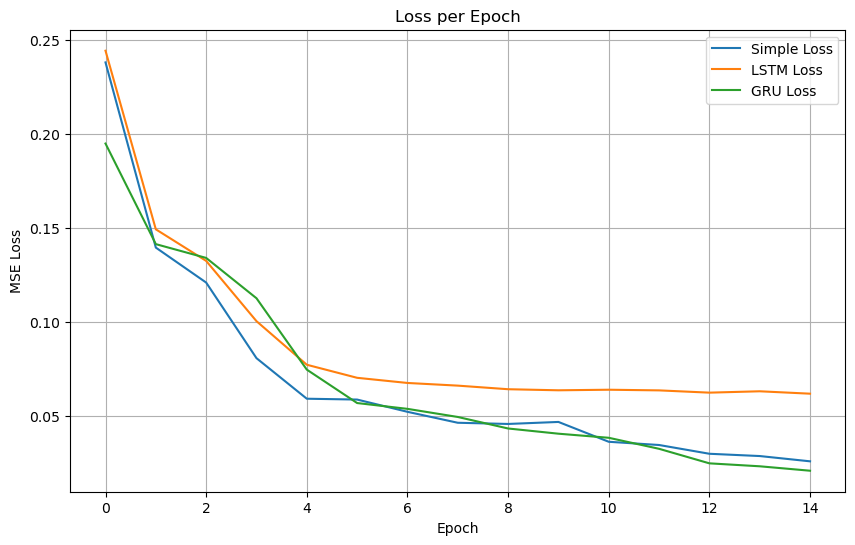

In [34]:
# Plot loss
plt.figure(figsize=(10, 6))
for key in loss_dict:
    plt.plot(loss_dict[key], label=f"{key} Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

Simple - MAE: 62.3499, MSE: 6125.2916
LSTM - MAE: 37.4495, MSE: 2020.4055
GRU - MAE: 61.1002, MSE: 5963.8577


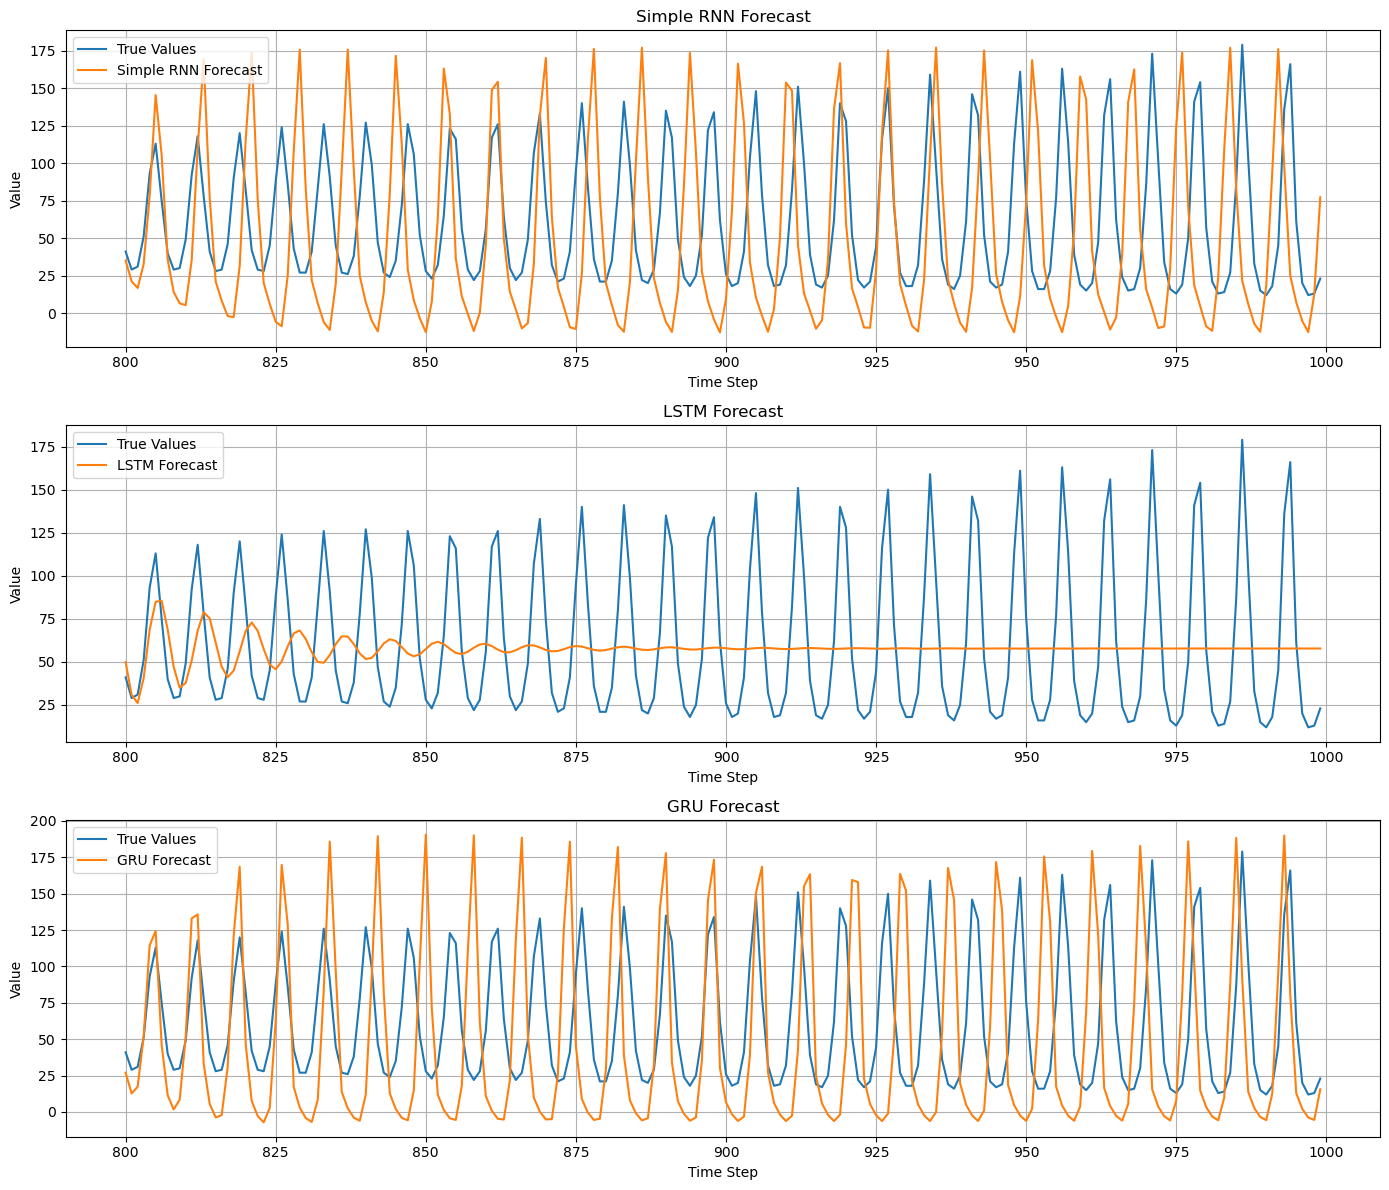

In [35]:
# Print results
for model_name, metrics in results.items():
    print(f"{model_name} - MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}")

# Plot in separate subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 12))

axs[0].plot(range(800, 1000), y_true_inv, label='True Values')
axs[0].plot(range(800, 1000), preds_Simple_inv, label='Simple RNN Forecast')
axs[0].set_title('Simple RNN Forecast')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(800, 1000), y_true_inv, label='True Values')
axs[1].plot(range(800, 1000), preds_LSTM_inv, label='LSTM Forecast')
axs[1].set_title('LSTM Forecast')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(range(800, 1000), y_true_inv, label='True Values')
axs[2].plot(range(800, 1000), preds_GRU_inv, label='GRU Forecast')
axs[2].set_title('GRU Forecast')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Value')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

## Evaluate differ

In [ ]:
# Evaluate different parameters in a loop
lookback_values = list(range(5, 105, 5))
forecast_steps = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store all forecasts
predictions_dict = {'Simple': [], 'LSTM': [], 'GRU': []}

# True future values
y_true = scaler.inverse_transform(dataset[800:].reshape(-1, 1)).flatten()

for lookback in lookback_values:
    train_data = dataset[:800]
    X_train, y_train = create_sequences(train_data, lookback)
    
    if len(X_train) == 0:
        for model_name in predictions_dict:
            predictions_dict[model_name].append(np.full((forecast_steps,), np.nan))
        continue

    X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

    for model_name in ['Simple', 'LSTM', 'GRU']:
        model = RNNModel(cell_type='RNN' if model_name == 'Simple' else model_name)
        model.to(device)
        train_model(model, X_train_torch, y_train_torch, epochs=10, batch_size=32, device=device)

        seed_input = train_data[-lookback:]
        pred = recursive_forecast(model, seed_input, forecast_steps, lookback, device)
        pred_inv = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
        predictions_dict[model_name].append(pred_inv)

C:\Users\cisva\AppData\Local\Temp\ipykernel_23964\3117586918.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
C:\Users\cisva\AppData\Local\Temp\ipykernel_23964\3117586918.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
C:\Users\cisva\AppData\Local\Temp\ipykernel_23964\3117586918.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas

In [ ]:
fig, axes = plt.subplots(3, len(lookback_values), figsize=(4 * len(lookback_values), 12), sharey=True)
model_names = ['Simple', 'LSTM', 'GRU']

for row, model_name in enumerate(model_names):
    for col, lookback in enumerate(lookback_values):
        ax = axes[row, col]
        ax.plot(range(800, 1000), y_true, label='True', color='black')
        ax.plot(range(800, 1000), predictions_dict[model_name][col], label=model_name, alpha=0.7)
        if row == 0:
            ax.set_title(f'Lookback: {lookback}')
        if col == 0:
            ax.set_ylabel(model_name)
        ax.tick_params(labelsize=8)
        ax.set_xticks([800, 850, 900, 950, 1000])
        ax.set_xlim(800, 1000)

fig.suptitle("Recursive Forecasts by Lookback Length and Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
mae_results, mse_results = [], []

for row, model_name in enumerate(model_names):
    for col, lookback in enumerate(lookback_values):
        y_pred = predictions_dict[model_name][col]
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        mae_results.append({'Model': model_name, 'Lookback': lookback, 'MAE': mae})
        mse_results.append({'Model': model_name, 'Lookback': lookback, 'MSE': mse})

mae_df = pd.DataFrame(mae_results)
mse_df = pd.DataFrame(mse_results)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.heatmap(mae_df.pivot('Model', 'Lookback', 'MAE'), annot=True, fmt=".2f", cmap='Blues')
plt.title("MAE Heatmap")

plt.subplot(1, 2, 2)
sns.heatmap(mse_df.pivot('Model', 'Lookback', 'MSE'), annot=True, fmt=".2f", cmap='Reds')
plt.title("MSE Heatmap")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=mae_df, x='Lookback', y='MAE', hue='Model')
plt.title('MAE vs Lookback')

plt.subplot(1, 2, 2)
sns.lineplot(data=mse_df, x='Lookback', y='MSE', hue='Model')
plt.title('MSE vs Lookback')
plt.tight_layout()
plt.show()


##Perform a grid search for optimal parameters

In [ ]:
param_grid = {
    'model_type': ['RNN', 'LSTM', 'GRU'],
    'lookback': [10, 15, 20, 25, 30, 35, 40, 45, 50],
    'hidden_size': [32, 64, 128, 256],
    'dropout': [0.1, 0.2, 0.25, 0.3],
    'lr': [0.001, 0.003, 0.0003],
    'batch_size': [16, 32, 64],
}
grid = list(itertools.product(*param_grid.values()))

In [ ]:
results = []

for params in grid:
    model_type, lookback, hidden_size, dropout, lr, batch_size = params

    # Create sequences
    X_train, y_train = create_sequences(train_data, lookback)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Define model
    model = RNNModel(cell_type=model_type, input_size=1, hidden_size=hidden_size, dropout=dropout)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Train
    model.train()
    for epoch in range(10):  # or use early stopping
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    # Forecast
    preds = recursive_forecast(model, train_data, 200, lookback, device)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(test_data.reshape(-1, 1))

    mse = mean_squared_error(y_true, preds)

    results.append({
        'params': dict(zip(param_grid.keys(), params)),
        'mse': mse
    })

    print(f"Finished: {params} => MSE: {mse:.4f}")

In [ ]:
best_run = min(results, key=lambda x: x['mse'])
print("Best Config:", best_run['params'])
print("Best MSE:", best_run['mse'])
